In [2]:
pip install biopython

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 16.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


1f3f.pdb exists. Skipping download.
1d4x.pdb exists. Skipping download.


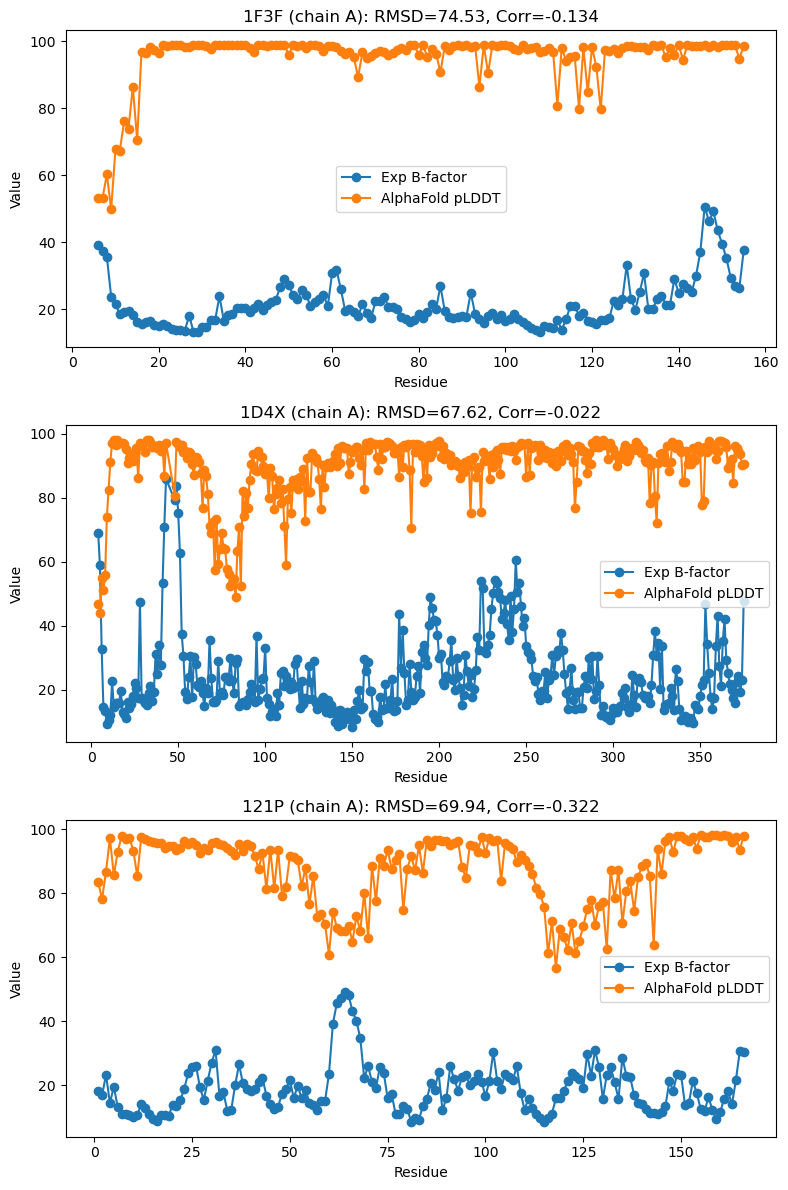


Summary of comparisons:
PDB: 1F3F Chain: A  Residues matched: 150  RMSD: 74.5310423450769  Corr: -0.13368107389938724
PDB: 1D4X Chain: A  Residues matched: 368  RMSD: 67.6200654402433  Corr: -0.022161624936206516
PDB: 121P Chain: A  Residues matched: 166  RMSD: 69.94233230687924  Corr: -0.3216653370771747


In [17]:

import os
import json
import requests
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# 1. Helper functions to parse data
###############################################################################

def download_pdb(pdb_id, out_dir="pdb_files"):
    """
    Download a PDB file by PDB ID from the RCSB server and save it locally.
    Skips download if the file already exists.
    Returns the local file path.
    """
    pdb_id = pdb_id.lower()
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    pdb_filepath = os.path.join(out_dir, f"{pdb_id}.pdb")
    
    if not os.path.isfile(pdb_filepath):
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        print(f"Downloading PDB {pdb_id} from {url}")
        response = requests.get(url)
        if response.status_code == 200:
            with open(pdb_filepath, "wb") as f:
                f.write(response.content)
        else:
            raise ValueError(f"Failed to download PDB {pdb_id} from RCSB. "
                             f"HTTP code: {response.status_code}")
    else:
        print(f"{pdb_id}.pdb exists. Skipping download.")
    return pdb_filepath

def parse_pdb_bfactors(pdb_file_path, chain_id="A"):
    """
    Parse B-factors from a PDB file for a given chain.
    Return (residue_ids, avg_b_factors).
    """
    residues = []
    b_factors = []
    current_res_id = None
    current_vals = []
    
    with open(pdb_file_path, "r") as pdb_file:
        for line in pdb_file:
            if not line.startswith("ATOM"):
                continue
            chain = line[21].strip()
            if chain != chain_id:
                continue
            
            res_num = line[22:26].strip()
            b_str = line[60:66].strip()
            if b_str == "":
                continue
            b_val = float(b_str)

            # If new residue or continuing the same one
            if current_res_id is None:
                # first residue
                current_res_id = res_num
                current_vals = [b_val]
            elif res_num == current_res_id:
                # same residue
                current_vals.append(b_val)
            else:
                # finalize previous residue
                residues.append(current_res_id)
                b_factors.append(np.mean(current_vals))
                # reset
                current_res_id = res_num
                current_vals = [b_val]
        
        # finalize last residue
        if current_res_id and current_vals:
            residues.append(current_res_id)
            b_factors.append(np.mean(current_vals))

    return residues, np.array(b_factors)

def load_alphafold_data(json_path, chain_id="A"):
    """
    Load pLDDTs from AlphaFold JSON for a specific chain (default A).
    Attempt to group them by residue.
    Return (residue_ids, avg_plddts).
    """
    with open(json_path, 'r') as f:
        af_data = json.load(f)
    
    atom_plddts = np.array(af_data["atom_plddts"])
    atom_chains = af_data["atom_chain_ids"]
    
    if "residue_index" in af_data:
        residue_idx = np.array(af_data["residue_index"])
        # Filter by chain
        chain_mask = np.array([ch == chain_id for ch in atom_chains])
        chain_plddts = atom_plddts[chain_mask]
        chain_res_idx = residue_idx[chain_mask]

        # Group by unique residue indices
        unique_res = []
        mean_plddts = []
        
        for r in np.unique(chain_res_idx):
            mask_r = (chain_res_idx == r)
            mean_plddts.append(chain_plddts[mask_r].mean())
            unique_res.append(r)
        
        return list(unique_res), np.array(mean_plddts)
    
    else:
        # If no residue_index, do a naive grouping
        chain_mask = [ch == chain_id for ch in atom_chains]
        chain_plddts = atom_plddts[chain_mask]
        
        # We'll pretend every 4 atoms = 1 residue (very approximate)
        group_size = 4
        residue_count = len(chain_plddts) // group_size
        
        splitted = np.array_split(chain_plddts, residue_count)
        mean_plddts = [arr.mean() for arr in splitted]
        residue_ids = list(range(1, residue_count+1))
        
        return residue_ids, np.array(mean_plddts)

def compute_rmsd(array1, array2):
    assert len(array1) == len(array2), "Arrays must match in length."
    diff = array1 - array2
    return np.sqrt(np.mean(diff**2))

###############################################################################
# 2. Main script to handle multiple files
###############################################################################

def main():
    """
    Example flow:
      - We have multiple proteins or data sets, each with an AlphaFold JSON file
        and a corresponding PDB ID (or local PDB file).
      - We parse each set, align them, compute metrics, store them, and finally
        plot everything in a single figure with multiple subplots.
    """
    # 1) Define data sets
    proteins = [
        {"pdb_id": "1F3F", "af_json": "fold_alphafold_1f3f_c_full_data_2.json", "chain": "A"},
        # Add as many entries as you have
        {"pdb_id": "1D4X", "af_json": "fold_alphafold_1d4x_a_full_data_1.json", "chain": "A"},
        {"pdb_id": "121P", "af_json": "fold_alphafold_121p_a_full_data_2.json", "chain": "A"},
        # {"pdb_id": "YYYY", "af_json": "fold_alphafold_YYYY.json", "chain": "B"},
    ]
    
    # Prepare lists/dicts for summarizing metrics across all proteins
    comparison_results = []
    
    # 2) Loop over each protein
    for prot in proteins:
        pdb_id = prot["pdb_id"]
        af_json_file = prot["af_json"]
        chain_id = prot.get("chain", "A")
        
        # Download PDB (or skip if you already have it locally)
        pdb_file = download_pdb(pdb_id, out_dir="pdb_files")
        
        # Parse B-factors from PDB
        residues_exp, bfactors_exp = parse_pdb_bfactors(pdb_file, chain_id=chain_id)
        
        # Load AlphaFold pLDDTs
        residues_af, plddts_af = load_alphafold_data(af_json_file, chain_id=chain_id)
        
        # Convert residue identifiers to a consistent type (numbers vs strings)
        # PDB residue IDs are strings, so let's cast them to int if possible:
        # (But sometimes PDB might have insertion codes, e.g., 45A.)
        def safe_int(x):
            # Try converting x to int, else fallback to string
            try:
                return int(x)
            except:
                return x
        
        residues_exp_int = [safe_int(r) for r in residues_exp]
        residues_af_int = [safe_int(r) for r in residues_af]
        
        # Build a matched set of common residues
        set_exp = set(residues_exp_int)
        set_af = set(residues_af_int)
        common = sorted(list(set_exp.intersection(set_af)), key=lambda x: int(x) if isinstance(x,int) else x)
        
        # Build matched arrays
        matched_bfact = []
        matched_plddt = []
        
        for r in common:
            i_exp = residues_exp_int.index(r)
            i_af = residues_af_int.index(r)
            matched_bfact.append(bfactors_exp[i_exp])
            matched_plddt.append(plddts_af[i_af])
        
        matched_bfact = np.array(matched_bfact)
        matched_plddt = np.array(matched_plddt)
        
        if len(matched_bfact) < 2:
            # Not enough data to do meaningful stats
            comparison_results.append({
                "pdb_id": pdb_id,
                "chain": chain_id,
                "rmsd": None,
                "corr": None,
                "res_count": len(matched_bfact),
                "common_residues": common
            })
            continue
        
        # Compute RMSD, correlation
        rmsd_val = compute_rmsd(matched_bfact, matched_plddt)
        corr_matrix = np.corrcoef(matched_bfact, matched_plddt)
        corr_val = corr_matrix[0, 1]
        
        comparison_results.append({
            "pdb_id": pdb_id,
            "chain": chain_id,
            "rmsd": rmsd_val,
            "corr": corr_val,
            "res_count": len(matched_bfact),
            "common_residues": common,
            "matched_bfactor": matched_bfact,
            "matched_plddt": matched_plddt
        })
    
    # 3) Plot results:
    #    We'll create one subplot per protein, plotting B-factor and pLDDT vs residue index.

    fig, axes = plt.subplots(len(comparison_results), 1, figsize=(8, 4*len(comparison_results)), sharex=False)
    if len(comparison_results) == 1:
        # If there's only one protein, axes is just a single subplot
        axes = [axes]

    for ax, result in zip(axes, comparison_results):
        if result["res_count"] is None or result["res_count"] < 2:
            ax.set_title(f"{result['pdb_id']} (chain {result['chain']}): Not enough data")
            continue
        
        xvals = result["common_residues"]
        y_bfact = result["matched_bfactor"]
        y_plddt = result["matched_plddt"]
        
        ax.plot(xvals, y_bfact, label="Exp B-factor", marker='o')
        ax.plot(xvals, y_plddt, label="AlphaFold pLDDT", marker='o')
        
        title_str = f"{result['pdb_id']} (chain {result['chain']}): RMSD={result['rmsd']:.2f}, Corr={result['corr']:.3f}"
        ax.set_title(title_str)
        ax.set_xlabel("Residue")
        ax.set_ylabel("Value")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

    # 4) If you want a summary table in the console:
    print("\nSummary of comparisons:")
    for r in comparison_results:
        print(f"PDB: {r['pdb_id']} Chain: {r['chain']}  "
              f"Residues matched: {r['res_count']}  "
              f"RMSD: {r['rmsd']}  Corr: {r['corr']}")

if __name__ == "__main__":
    main()
